In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import (
    linear_model, metrics, neural_network, pipeline, preprocessing, model_selection
)
from geopy.distance import geodesic as GD
from geopy.distance import great_circle as GRC
from scipy.stats import pearsonr
from scipy.stats import linregress

In [3]:
#Importing Datasets
sent = pd.read_csv('Sentence_Data.csv')
crime = pd.read_csv('Crime_Data.csv')
diversion = pd.read_csv('Diversion_Data.csv')
crime

/var/folders/md/_w6bxcps70gc_gzhk5rkxtw00000gn/T/ipykernel_1209/2307516995.py:2: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  sent = pd.read_csv('Sentence_Data.csv')


,id,case_number,date,block,IUCR,primary_type,description,location_description,arrest,domestic,...,longitude,location,geometry,index_right,state_fips_code,county_fips_code,census_tract_code,geo_id,area_name,name_legal_stat_area_desc
0,11037294,JA371270,2015-03-18 12:00:00,0000X W WACKER DR,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,BANK,False,False,...,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11645601,JC212935,2014-06-01 00:01:00,087XX S SANGAMON ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11645527,JC212744,2015-02-02 10:00:00,069XX W ARCHER AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,OTHER,False,False,...,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11645833,JC213044,2012-05-05 12:25:00,057XX W OHIO ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11648237,JC216157,2012-01-01 12:00:00,115XX S CAMPBELL AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,NaN,NaN,POINT EMPTY,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463134,12131776,JD327752,2020-08-10 20:30:00,066XX S SACRAMENTO AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,-87.698104,"(41.772671069, -87.698104059)",POINT (-87.698104059 41.772671069),1292.0,17.0,31.0,660800.0,1.703166e+10,6608.00,Census Tract 6608
3463135,12082414,JD269218,2020-06-18 21:00:00,093XX S DR MARTIN LUTHER KING JR DR,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,-87.614211,"(41.724546436, -87.614210743)",POINT (-87.614210743 41.724546436),365.0,17.0,31.0,490200.0,1.703149e+10,4902.00,Census Tract 4902
3463136,12118237,JD311791,2020-07-27 15:02:00,033XX W POLK ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,-87.709461,"(41.870920735, -87.709461362)",POINT (-87.709461362 41.870920735),2208.0,17.0,31.0,837300.0,1.703184e+10,8373.00,Census Tract 8373
3463137,12142591,JD340297,2020-08-14 15:00:00,023XX W ROSEMONT AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,-87.688929,"(41.995927389, -87.688928533)",POINT (-87.688928533 41.995927389),1908.0,17.0,31.0,20901.0,1.703102e+10,209.01,Census Tract 209.01


THEFT                                774371
BATTERY                              627584
CRIMINAL DAMAGE                      375163
ASSAULT                              247952
NARCOTICS                            236314
DECEPTIVE PRACTICE                   215255
OTHER OFFENSE                        211800
MOTOR VEHICLE THEFT                  174500
BURGLARY                             172354
ROBBERY                              132972
CRIMINAL TRESPASS                     81156
WEAPONS VIOLATION                     70442
OFFENSE INVOLVING CHILDREN            29147
PUBLIC PEACE VIOLATION                23803
SEX OFFENSE                           14346
PROSTITUTION                          13008
INTERFERENCE WITH PUBLIC OFFICER      12946
CRIM SEXUAL ASSAULT                   12164
HOMICIDE                               7699
CRIMINAL SEXUAL ASSAULT                7165
ARSON                                  5823
LIQUOR LAW VIOLATION                   3934
GAMBLING                        

0486    305267
0820    303124
0460    204890
0810    195129
1320    177290
         ...  
0830         1
2111         1
1542         1
1627         1
0130         1
Name: IUCR, Length: 380, dtype: int64

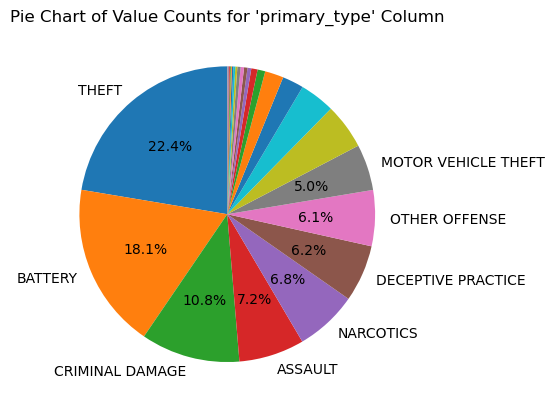

In [85]:
primary_type_counts = crime['primary_type'].value_counts()
iucr_counts = crime['IUCR'].value_counts()
display(primary_type_counts)
display(iucr_counts)

labels = primary_type_counts.index.map(lambda x: x if primary_type_counts[x] / primary_type_counts.sum() * 100 > 5 else '')
plt.pie(primary_type_counts, autopct=lambda p: f'{p:.1f}%' if p >= 5 else '', startangle=90, labels=labels)


# Add a title
plt.title("Pie Chart of Value Counts for '{}' Column".format('primary_type'))

# Display the pie chart
plt.show()

In [5]:
print(crime['name_legal_stat_area_desc'].isna().sum())
print('Percentage of crimes with loc:')
print((crime.shape[0]-crime['name_legal_stat_area_desc'].isna().sum())/crime.shape[0])

#can look at community areas separately

43196
Percentage of crimes with loc:
0.9875269228292598


In [6]:
crime_w_loc = crime.dropna(subset=['name_legal_stat_area_desc'])
crime_w_loc

,id,case_number,date,block,IUCR,primary_type,description,location_description,arrest,domestic,...,longitude,location,geometry,index_right,state_fips_code,county_fips_code,census_tract_code,geo_id,area_name,name_legal_stat_area_desc
50,10321198,HY510596,2015-11-21 23:41:00,050XX N HARLEM AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,-87.807088,"(41.97209549, -87.807087563)",POINT (-87.807087563 41.97209549),2108.0,17.0,31.0,770901.0,1.703177e+10,7709.01,Census Tract 7709.01
127,8029377,HT260540,2011-04-22 02:40:00,063XX S DR MARTIN LUTHER KING JR DR,0420,BATTERY,AGGRAVATED - KNIFE / CUTTING INSTRUMENT,RESTAURANT,False,False,...,-87.615597,"(41.779059693, -87.615596501)",POINT (-87.615596501 41.779059693),1196.0,17.0,31.0,420700.0,1.703142e+10,4207.00,Census Tract 4207
143,20847,HW229606,2013-04-12 08:30:00,067XX S KEDZIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,PARK PROPERTY,True,False,...,-87.702945,"(41.770565416, -87.702945412)",POINT (-87.702945412 41.770565416),1293.0,17.0,31.0,660900.0,1.703166e+10,6609.00,Census Tract 6609
144,9738557,HX388244,2014-08-15 03:49:00,030XX W JACKSON BLVD,0263,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - KNIFE / CUTTING INSTRUMENT,APARTMENT,False,False,...,-87.702899,"(41.877353099, -87.702899477)",POINT (-87.702899477 41.877353099),909.0,17.0,31.0,271200.0,1.703127e+10,2712.00,Census Tract 2712
153,9811586,HX460306,2014-10-08 18:33:00,093XX S MICHIGAN AVE,031A,ROBBERY,ARMED - HANDGUN,STREET,False,False,...,-87.620662,"(41.724476858, -87.620662432)",POINT (-87.620662432 41.724476858),365.0,17.0,31.0,490200.0,1.703149e+10,4902.00,Census Tract 4902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463134,12131776,JD327752,2020-08-10 20:30:00,066XX S SACRAMENTO AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,-87.698104,"(41.772671069, -87.698104059)",POINT (-87.698104059 41.772671069),1292.0,17.0,31.0,660800.0,1.703166e+10,6608.00,Census Tract 6608
3463135,12082414,JD269218,2020-06-18 21:00:00,093XX S DR MARTIN LUTHER KING JR DR,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,-87.614211,"(41.724546436, -87.614210743)",POINT (-87.614210743 41.724546436),365.0,17.0,31.0,490200.0,1.703149e+10,4902.00,Census Tract 4902
3463136,12118237,JD311791,2020-07-27 15:02:00,033XX W POLK ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,-87.709461,"(41.870920735, -87.709461362)",POINT (-87.709461362 41.870920735),2208.0,17.0,31.0,837300.0,1.703184e+10,8373.00,Census Tract 8373
3463137,12142591,JD340297,2020-08-14 15:00:00,023XX W ROSEMONT AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,-87.688929,"(41.995927389, -87.688928533)",POINT (-87.688928533 41.995927389),1908.0,17.0,31.0,20901.0,1.703102e+10,209.01,Census Tract 209.01


8391.00    43433
3201.02    23736
2315.00    19077
2518.00    18165
2312.00    17909
           ...  
8076.00        8
8116.00        5
8232.00        4
8142.00        2
8080.01        1
Name: area_name, Length: 854, dtype: int64

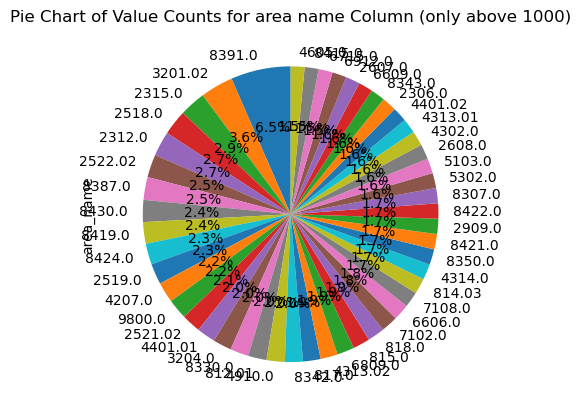

In [7]:
area_crime_counts = crime_w_loc['area_name'].value_counts()
area_crime_counts.to_frame()
display(area_crime_counts)

#filtering only values above 1000:
filtered_ac_counts = area_crime_counts[area_crime_counts > 10000]

# Plot a pie chart
filtered_ac_counts.plot.pie(autopct='%1.1f%%', startangle=90, legend=False)
# Add a title
plt.title("Pie Chart of Value Counts for area name Column (only above 1000)")
# Display the pie chart
plt.show()

       area_name primary_type  Count
2         101.00      BATTERY   1675
30        102.01      BATTERY   1170
79        102.02        THEFT   3070
107       103.00        THEFT   1314
133       104.00        THEFT   1267
...          ...          ...    ...
20818    8439.00      BATTERY   1709
20848    8446.00      BATTERY    692
20872    8447.00      BATTERY   1495
20918    9800.00        THEFT   4620
20943    9801.00        THEFT   1200

[854 rows x 3 columns]
No of total areas: 854


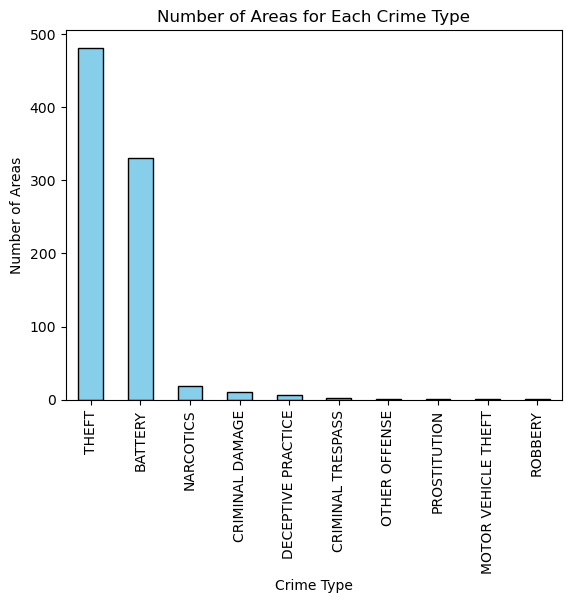

In [8]:
# Group by 'ZipCode' and 'CrimeType', then count occurrences
crime_counts = crime_w_loc.groupby(['area_name', 'primary_type']).size().reset_index(name='Count')

# Find the row with the highest count for each 'ZipCode'
max_crime_counts = crime_counts.loc[crime_counts.groupby('area_name')['Count'].idxmax()]

# Print the result
print(max_crime_counts)

area_count = crime_w_loc['area_name'].nunique()
print('No of total areas: {}'.format(area_count))

# Find the total number of area names for each 'CrimeType'
crime_type_counts = max_crime_counts['primary_type'].value_counts()

# Plot a bar chart
crime_type_counts.plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Crime Type')
plt.ylabel('Number of Areas')
plt.title('Number of Areas for Each Crime Type')

# Display the bar chart
plt.show()

Coniviction DF

In [9]:
sent

,case_id,case_participant_id,received_date,offense_category,primary_charge_flag,charge_id,charge_version_id,disposition_charged_offense_title,charge_count,disposition_date,...,incident_city,incident_begin_date,incident_end_date,law_enforcement_agency,law_enforcement_unit,arrest_date,felony_review_date,felony_review_result,arraignment_date,updated_offense_category
0,167083341487,670458920516,09/02/2009 12:00:00 AM,PROMIS Conversion,False,2409768744879,1904567115404,ATTEMPT FIRST DEGREE MURDER,4,04/15/2014 12:00:00 AM,...,Chicago,09/15/2008 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,2011-07-27 19:39:00,07/28/2011 12:00:00 AM,Approved,09/12/2011 12:00:00 AM,PROMIS Conversion
1,167083341487,670458920516,09/02/2009 12:00:00 AM,PROMIS Conversion,False,2409776412625,1904573170441,AGGRAVATED BATTERY WITH A FIREARM,7,04/15/2014 12:00:00 AM,...,Chicago,09/15/2008 12:00:00 AM,NaN,CHICAGO POLICE DEPT,NaN,2011-07-27 19:39:00,07/28/2011 12:00:00 AM,Approved,09/12/2011 12:00:00 AM,PROMIS Conversion
2,224609276363,386948574911,09/16/1994 12:00:00 AM,Attempt Homicide,False,2501088814098,1977664901643,AGGRAVATED BATTERY WITH A FIREARM,2,10/29/2012 12:00:00 AM,...,Chicago,09/15/1994 12:00:00 AM,NaN,CHICAGO PD,NaN,2012-08-07 09:00:00,08/09/2012 12:00:00 AM,Approved,09/18/2012 12:00:00 AM,Attempt Homicide
3,224609276363,386948574911,09/16/1994 12:00:00 AM,Attempt Homicide,False,2501089511166,1977665452101,HOME INVASION,3,10/29/2012 12:00:00 AM,...,Chicago,09/15/1994 12:00:00 AM,NaN,CHICAGO PD,NaN,2012-08-07 09:00:00,08/09/2012 12:00:00 AM,Approved,09/18/2012 12:00:00 AM,Attempt Homicide
4,224609276363,386948574911,09/16/1994 12:00:00 AM,Attempt Homicide,True,2501092299437,1977667653932,ATTEMPT MURDER,1,10/29/2012 12:00:00 AM,...,Chicago,09/15/1994 12:00:00 AM,NaN,CHICAGO PD,NaN,2012-08-07 09:00:00,08/09/2012 12:00:00 AM,Approved,09/18/2012 12:00:00 AM,Attempt Homicide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171537,328231995902,2898672574287,07/14/2023 12:00:00 AM,Narcotics,True,3233924945811,2572433324181,POSS CAN/>10-30 GRAM/1ST,1,08/11/2023 12:00:00 AM,...,Chicago,07/12/2023 12:00:00 AM,NaN,COOK COUNTY SHERIFF (IL0160000),NaN,2023-07-12 20:20:00,NaN,NaN,NaN,Narcotics
171538,328254576899,2899010996037,07/17/2023 12:00:00 AM,Narcotics,True,3234279056273,2573309653213,ATTEMPT POSSESSION OF A CONTROLLED SUBSTANCE,1,08/23/2023 12:00:00 AM,...,Chicago,07/13/2023 12:00:00 AM,NaN,CHICAGO PD,District 11 - Harrison,2023-07-13 22:08:00,NaN,NaN,08/16/2023 12:00:00 AM,Narcotics
171539,328255737604,2899026723038,07/17/2023 12:00:00 AM,UUW - Unlawful Use of Weapon,True,3235155270545,2573330295386,DISORDERLY CONDUCT,1,08/22/2023 12:00:00 AM,...,Chicago,07/17/2023 12:00:00 AM,NaN,CHICAGO PD,NaN,2023-07-17 13:25:00,07/17/2023 12:00:00 AM,Approved,NaN,UUW - Unlawful Use of Weapon
171540,328332660722,2900180618884,07/26/2023 12:00:00 AM,Narcotics,True,3235727563241,2573547451041,RESIST/OBSTRUCT OFFICER,1,08/15/2023 12:00:00 AM,...,Chicago,07/24/2023 12:00:00 AM,NaN,CHICAGO PD,District 10 - Ogden,2023-07-24 12:53:00,NaN,NaN,NaN,Narcotics


Narcotics                       52482
UUW - Unlawful Use of Weapon    31183
Aggravated DUI                  10870
Burglary                         7156
Retail Theft                     6791
                                ...  
Gambling                           12
PROMIS Conversion                   4
DUI                                 3
Pandering                           3
Possession of Explosives            1
Name: updated_offense_category, Length: 74, dtype: int64

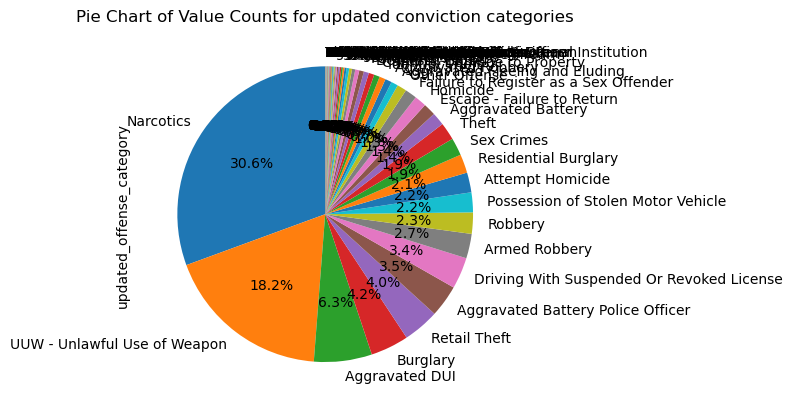

In [10]:
conv_categories = sent['updated_offense_category'].value_counts()
display(conv_categories)

# Plot a pie chart
conv_categories.plot.pie(autopct='%1.1f%%', startangle=90, legend=False)
# Add a title
plt.title("Pie Chart of Value Counts for updated conviction categories")
# Display the pie chart
plt.show()

In [11]:
conv_types = sent['charge_disposition'].value_counts()
display(conv_types)

Plea Of Guilty                      154460
Finding Guilty                       13767
Verdict Guilty                        2245
Case Dismissed                         539
Nolle Prosecution                      209
FNG Reason Insanity                     72
Finding Not Not Guilty                  65
Charge Vacated                          34
Finding Guilty - Lesser Included        29
Plea of Guilty But Mentally Ill         24
Plea of Guilty - Amended Charge         21
FNG                                     18
BFW                                     17
Finding Guilty But Mentally Ill         12
Sexually Dangerous Person                7
Nolle On Remand                          4
Verdict Guilty - Lesser Included         4
Death Suggested-Cause Abated             4
WOWI                                     3
Charge Reversed                          2
Plea of Guilty - Lesser Included         2
SOLW                                     1
Superseded by Indictment                 1
Finding Gui

Diversion

In [12]:
diversion

,case_id,case_participant_id,received_date,offense_category,diversion_program,referral_date,diversion_count,primary_charge_offense_title,statute,race,gender,diversion_result,diversion_closed_date,incident_city,arrest_date,age_at_incident
0,274959941057,2193361164603,01/01/2011 12:00:00 AM,Retail Theft,DS,06/17/2013 12:00:00 AM,2,RETAIL THEFT,720 ILCS 5/16A-3(a),Black,Male,Graduated,06/17/2013 12:00:00 AM,Chicago,2011-01-01 16:24:00,52.0
1,274959941057,2193361164603,01/01/2011 12:00:00 AM,Retail Theft,VC,08/11/2011 12:00:00 AM,1,RETAIL THEFT,720 ILCS 5/16A-3(a),Black,Male,NaN,NaN,Chicago,2011-01-01 16:24:00,52.0
2,274962262468,2193390288678,01/02/2011 12:00:00 AM,Retail Theft,MHC,09/14/2012 12:00:00 AM,1,RETAIL THEFT,720 ILCS 5/16A-3(a),Black,Male,Failed,09/14/2012 12:00:00 AM,Chicago,2011-01-02 13:45:00,52.0
3,274971231556,2193494552866,01/03/2011 12:00:00 AM,Narcotics,DS,01/19/2011 12:00:00 AM,1,POSSESSION OF A CONTROLLED SUBSTANCE,720 ILCS 570/402(c),White,Male,Graduated,05/13/2011 12:00:00 AM,Chicago,2011-01-01 23:30:00,45.0
4,274983577241,2193661725056,01/04/2011 12:00:00 AM,Narcotics,DS,01/19/2011 12:00:00 AM,1,POSSESSION OF A CONTROLLED SUBSTANCE,720 ILCS 570/402(c),White,Female,Graduated,05/13/2011 12:00:00 AM,Chicago,2011-01-01 02:15:00,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16119,328650905058,2904969490517,08/31/2023 12:00:00 AM,Narcotics,DDPP,08/24/2023 12:00:00 AM,1,POSSESSION OF A CONTROLLED SUBSTANCE,720 ILCS 570/402(c),White,Male,NaN,NaN,Chicago,2023-08-23 12:03:00,27.0
16120,328651116095,2904971237961,08/31/2023 12:00:00 AM,Narcotics,DDPP,08/24/2023 12:00:00 AM,1,POSS CAN/>100-500 GRAM/1ST,720 ILCS 550/4(d),Black,Male,NaN,NaN,Chicago,2023-08-23 21:07:00,32.0
16121,328651538170,2904976480295,08/31/2023 12:00:00 AM,Narcotics,DDPP,08/25/2023 12:00:00 AM,1,POSSESSION OF A CONTROLLED SUBSTANCE,720 ILCS 570/402(c),Latinx,Male,NaN,NaN,Chicago,2023-08-24 22:44:00,37.0
16122,328651749207,2904978518980,08/31/2023 12:00:00 AM,Narcotics,DDPP,08/29/2023 12:00:00 AM,1,POSSESSION OF A CONTROLLED SUBSTANCE,720 ILCS 570/402(c),Unknown,Unknown,NaN,NaN,Chicago,2023-08-28 10:05:00,44.0


In [13]:
diversion['primary_charge_offense_title'].value_counts()

POSSESSION OF A CONTROLLED SUBSTANCE                                                              8806
RETAIL THEFT                                                                                      1429
[POSSESSION OF CONTROLLED SUBSTANCE WITH INTENT TO DELIVER/DELIVERY OF A CONTROLLED SUBSTANCE]     964
BURGLARY                                                                                           538
THEFT                                                                                              519
                                                                                                  ... 
THEFT/DAMAGE/FACILITY>300-10K                                                                        1
POSS 3+ LOST CREDIT/DEBIT CARD                                                                       1
ARSON/REAL/PERSONAL PROP>$150                                                                        1
OFFL MISCONDUCT/FORBIDDEN ACT                                            

Breakdown crime by Police District and then measure correlation between number of crimes and distance from police station

In [14]:
locs = pd.read_csv('civic_locations.csv')
locs_p = locs.dropna(subset=['DISTRICT'])
locs_p = locs_p[1:]
locs_p['DISTRICT'] = pd.to_numeric(locs_p['DISTRICT'], errors='coerce')
locs_p.set_index('DISTRICT', inplace=True)
locs_po = locs_p.sort_index()
police_locs = pd.DataFrame()
police_locs.index = locs_po.index
police_locs['LATITUDE'] = locs_po['LATITUDE']
police_locs['LONGITUDE'] = locs_po['LONGITUDE']
police_locs

,LATITUDE,LONGITUDE
DISTRICT,,
1,41.858373,-87.627356
2,41.801811,-87.630560
3,41.766431,-87.605748
4,41.707933,-87.568349
5,41.692723,-87.604506
6,41.752137,-87.644229
7,41.779632,-87.660887
8,41.778987,-87.708864
9,41.837394,-87.646408


In [38]:
pd_crime_counts = crime_w_loc['district'].value_counts()
pd_crime_counts.to_frame()
display(pd_crime_counts)


11.0    229827
8.0     221558
6.0     209832
4.0     198200
25.0    187570
7.0     186568
3.0     170824
12.0    170726
18.0    163327
9.0     158995
1.0     158753
19.0    156597
10.0    154935
5.0     152434
2.0     149646
15.0    140568
14.0    121428
16.0    117222
22.0    111100
24.0    102234
17.0     97521
20.0     59952
31.0       125
Name: district, dtype: int64

In [16]:
def calculate_distance(row, df_p):
    district = row['district']
    
    # Check if the district is present in locs_p
    if district in police_locs.index:
        pol_lat = df_p.loc[district, 'LATITUDE']
        pol_lon = df_p.loc[district, 'LONGITUDE']

        pol_loc = (pol_lat, pol_lon)
        c_loc = (row['latitude'], row['longitude'])

        dist = GRC(pol_loc, c_loc).km
        return dist
    else:
        return None

# Assuming crime_w_loc and locs_p are your DataFrames
crime_w_loc['Distance'] = crime_w_loc.apply(lambda row: calculate_distance(row, locs_p), axis=1)

crime_w_loc

/var/folders/md/_w6bxcps70gc_gzhk5rkxtw00000gn/T/ipykernel_1209/332620868.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  crime_w_loc['Distance'] = crime_w_loc.apply(lambda row: calculate_distance(row, locs_p), axis=1)


,id,case_number,date,block,IUCR,primary_type,description,location_description,arrest,domestic,...,location,geometry,index_right,state_fips_code,county_fips_code,census_tract_code,geo_id,area_name,name_legal_stat_area_desc,Distance
50,10321198,HY510596,2015-11-21 23:41:00,050XX N HARLEM AVE,0560,ASSAULT,SIMPLE,OTHER,False,False,...,"(41.97209549, -87.807087563)",POINT (-87.807087563 41.97209549),2108.0,17.0,31.0,770901.0,1.703177e+10,7709.01,Census Tract 7709.01,3.391654
127,8029377,HT260540,2011-04-22 02:40:00,063XX S DR MARTIN LUTHER KING JR DR,0420,BATTERY,AGGRAVATED - KNIFE / CUTTING INSTRUMENT,RESTAURANT,False,False,...,"(41.779059693, -87.615596501)",POINT (-87.615596501 41.779059693),1196.0,17.0,31.0,420700.0,1.703142e+10,4207.00,Census Tract 4207,1.624500
143,20847,HW229606,2013-04-12 08:30:00,067XX S KEDZIE AVE,0110,HOMICIDE,FIRST DEGREE MURDER,PARK PROPERTY,True,False,...,"(41.770565416, -87.702945412)",POINT (-87.702945412 41.770565416),1293.0,17.0,31.0,660900.0,1.703166e+10,6609.00,Census Tract 6609,1.057275
144,9738557,HX388244,2014-08-15 03:49:00,030XX W JACKSON BLVD,0263,CRIMINAL SEXUAL ASSAULT,AGGRAVATED - KNIFE / CUTTING INSTRUMENT,APARTMENT,False,False,...,"(41.877353099, -87.702899477)",POINT (-87.702899477 41.877353099),909.0,17.0,31.0,271200.0,1.703127e+10,2712.00,Census Tract 2712,0.470899
153,9811586,HX460306,2014-10-08 18:33:00,093XX S MICHIGAN AVE,031A,ROBBERY,ARMED - HANDGUN,STREET,False,False,...,"(41.724476858, -87.620662432)",POINT (-87.620662432 41.724476858),365.0,17.0,31.0,490200.0,1.703149e+10,4902.00,Census Tract 4902,3.644608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3463134,12131776,JD327752,2020-08-10 20:30:00,066XX S SACRAMENTO AVE,0620,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,...,"(41.772671069, -87.698104059)",POINT (-87.698104059 41.772671069),1292.0,17.0,31.0,660800.0,1.703166e+10,6608.00,Census Tract 6608,1.135501
3463135,12082414,JD269218,2020-06-18 21:00:00,093XX S DR MARTIN LUTHER KING JR DR,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,...,"(41.724546436, -87.614210743)",POINT (-87.614210743 41.724546436),365.0,17.0,31.0,490200.0,1.703149e+10,4902.00,Census Tract 4902,3.951669
3463136,12118237,JD311791,2020-07-27 15:02:00,033XX W POLK ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,...,"(41.870920735, -87.709461362)",POINT (-87.709461362 41.870920735),2208.0,17.0,31.0,837300.0,1.703184e+10,8373.00,Census Tract 8373,0.442512
3463137,12142591,JD340297,2020-08-14 15:00:00,023XX W ROSEMONT AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,"(41.995927389, -87.688928533)",POINT (-87.688928533 41.995927389),1908.0,17.0,31.0,20901.0,1.703102e+10,209.01,Census Tract 209.01,1.516006


In [40]:
#Sorting data by distance
crime_dropped = crime_w_loc.dropna(subset=['Distance'])
sorted_crime = crime_dropped.sort_values(by='Distance')
sorted_crime

,id,case_number,date,block,IUCR,primary_type,description,location_description,arrest,domestic,...,location,geometry,index_right,state_fips_code,county_fips_code,census_tract_code,geo_id,area_name,name_legal_stat_area_desc,Distance
782220,9057304,HW201954,2013-03-21 13:24:00,033XX W OGDEN SD,4651,OTHER OFFENSE,SEX OFFENDER: FAIL REG NEW ADD,POLICE FACILITY/VEH PARKING LOT,True,False,...,"(41.856691604, -87.708421363)",POINT (-87.708421363 41.856691604),367.0,17.0,31.0,844700.0,1.703184e+10,8447.00,Census Tract 8447,0.003357
2349943,11411730,JB390458,2018-08-12 16:20:00,033XX W OGDEN SD,0498,BATTERY,AGGRAVATED DOMESTIC BATTERY: HANDS/FIST/FEET S...,STREET,True,True,...,"(41.856691604, -87.708421363)",POINT (-87.708421363 41.856691604),367.0,17.0,31.0,844700.0,1.703184e+10,8447.00,Census Tract 8447,0.003357
1241824,9898470,HX548746,2014-12-19 22:30:00,033XX W OGDEN SD,2093,NARCOTICS,FOUND SUSPECT NARCOTICS,POLICE FACILITY/VEH PARKING LOT,True,False,...,"(41.856691604, -87.708421363)",POINT (-87.708421363 41.856691604),367.0,17.0,31.0,844700.0,1.703184e+10,8447.00,Census Tract 8447,0.003357
620915,8837021,HV510315,2012-10-08 15:00:00,033XX W OGDEN SD,5001,OTHER OFFENSE,OTHER CRIME INVOLVING PROPERTY,SIDEWALK,False,False,...,"(41.856691604, -87.708421363)",POINT (-87.708421363 41.856691604),367.0,17.0,31.0,844700.0,1.703184e+10,8447.00,Census Tract 8447,0.003357
2005672,11096900,JA442433,2017-09-22 18:05:00,033XX W OGDEN SD,0460,BATTERY,SIMPLE,SIDEWALK,False,False,...,"(41.856691604, -87.708421363)",POINT (-87.708421363 41.856691604),367.0,17.0,31.0,844700.0,1.703184e+10,8447.00,Census Tract 8447,0.003357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1703162,10795856,HZ566595,2016-12-27 11:52:00,031XX W 113TH ST,2024,NARCOTICS,POSS: HEROIN(WHITE),SIDEWALK,True,False,...,"(41.687925772, -87.699956217)",POINT (-87.699956217 41.687925772),1035.0,17.0,31.0,740100.0,1.703174e+10,7401.00,Census Tract 7401,18.778149
2050559,11138163,JA456549,2017-10-02 17:00:00,057XX S CICERO AVE,2091,NARCOTICS,FORFEIT PROPERTY,AIRPORT/AIRCRAFT,True,False,...,"(41.788987036, -87.74147999)",POINT (-87.74147999 41.788987036),2130.0,17.0,31.0,980100.0,1.703198e+10,9801.00,Census Tract 9801,20.684105
2077287,11141350,JA451374,2017-09-18 17:00:00,057XX S CICERO AVE,2091,NARCOTICS,FORFEIT PROPERTY,AIRPORT/AIRCRAFT,True,False,...,"(41.788987036, -87.74147999)",POINT (-87.74147999 41.788987036),2130.0,17.0,31.0,980100.0,1.703198e+10,9801.00,Census Tract 9801,20.684105
2056990,11137419,JA416172,2017-09-02 14:56:00,056XX S HERMITAGE AVE,2017,NARCOTICS,MANU/DELIVER:CRACK,VEHICLE NON-COMMERCIAL,True,False,...,"(41.791450983, -87.668168083)",POINT (-87.668168083 41.791450983),1312.0,17.0,31.0,670300.0,1.703167e+10,6703.00,Census Tract 6703,21.015151


In [56]:
#Counting number of values below i km
agg_crime_dist = pd.DataFrame(columns=['Distance', 'Count'])
count_list = []
agg_list = []
for i in range(1, 21):
    count_below_i = (sorted_crime['Distance'] < i).sum()
    agg_list.append(count_below_i)

print(len(agg_list))

idx_lst = []
count_list = agg_list.copy()
for i in range(1, 20):
    idx_lst.append(i)
    count_list[i] = agg_list[i] - agg_list[i-1]
idx_lst.append(20)

agg_crime_dist['Distance'] = idx_lst
agg_crime_dist['Count'] = count_list

agg_crime_dist

20


,Distance,Count
0,1,557127
1,2,1099618
2,3,876517
3,4,513872
4,5,227406
5,6,104743
6,7,20777
7,8,4093
8,9,67
9,10,1992


In [57]:
# Perform correlation analysis
correlation_coefficient = agg_crime_dist['Distance'].corr(agg_crime_dist['Count'])

# Print the correlation coefficient
print(correlation_coefficient)

-0.716836534054369


Slope: -39609.68646616542
Intercept: 586892.3578947369
R-squared: 0.5138546165550808
P-value: 0.00037587209566778535
Standard Error: 9080.883494372158


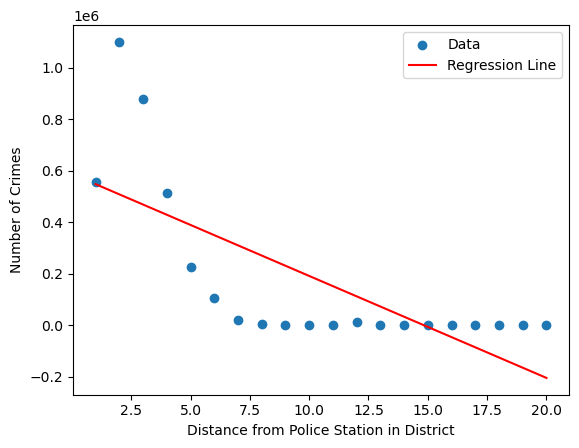

In [60]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(agg_crime_dist['Distance'], agg_crime_dist['Count'])

# Print the regression results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

# Plot the data and the regression line
plt.scatter(agg_crime_dist['Distance'], agg_crime_dist['Count'], label='Data')
plt.plot(agg_crime_dist['Distance'], intercept + slope * agg_crime_dist['Distance'], 'r', label='Regression Line')
plt.xlabel('Distance from Police Station in District')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

In [80]:
#Checking dist and crime pattern for south (4th) and West (8th)
dist_4 = sorted_crime[sorted_crime['district'] == 4]
dist_8 = sorted_crime[sorted_crime['district'] == 8]
dist_4

,id,case_number,date,block,IUCR,primary_type,description,location_description,arrest,domestic,...,location,geometry,index_right,state_fips_code,county_fips_code,census_tract_code,geo_id,area_name,name_legal_stat_area_desc,Distance
3249349,13089590,JG280119,2023-05-29 21:04:00,103XX S LUELLA AVE,141B,WEAPONS VIOLATION,UNLAWFUL USE - OTHER FIREARM,STREET,False,False,...,"(41.707813113, -87.568131906)",POINT (-87.568131906 41.707813113),242.0,17.0,31.0,838800.0,1.703184e+10,8388.0,Census Tract 8388,0.022443
74068,8070323,HT302350,2011-05-18 18:30:00,103XX S LUELLA AVE,2093,NARCOTICS,FOUND SUSPECT NARCOTICS,POLICE FACILITY/VEH PARKING LOT,True,False,...,"(41.707813113, -87.568131906)",POINT (-87.568131906 41.707813113),242.0,17.0,31.0,838800.0,1.703184e+10,8388.0,Census Tract 8388,0.022443
986395,9343047,HW486736,2013-10-09 07:30:00,103XX S LUELLA AVE,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,"(41.707813113, -87.568131906)",POINT (-87.568131906 41.707813113),242.0,17.0,31.0,838800.0,1.703184e+10,8388.0,Census Tract 8388,0.022443
1719235,10620978,HZ372892,2016-07-31 19:30:00,103XX S LUELLA AVE,4387,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,PARKING LOT/GARAGE(NON.RESID.),False,True,...,"(41.707813113, -87.568131906)",POINT (-87.568131906 41.707813113),242.0,17.0,31.0,838800.0,1.703184e+10,8388.0,Census Tract 8388,0.022443
1573361,10529642,HZ272517,2016-05-20 15:41:00,103XX S LUELLA AVE,2825,OTHER OFFENSE,HARASSMENT BY TELEPHONE,STREET,False,False,...,"(41.707813113, -87.568131906)",POINT (-87.568131906 41.707813113),242.0,17.0,31.0,838800.0,1.703184e+10,8388.0,Census Tract 8388,0.022443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2909430,12431132,JE310702,2021-07-22 20:21:00,137XX S AVENUE O,0460,BATTERY,SIMPLE,RESTAURANT,False,False,...,"(41.645287658, -87.540012254)",POINT (-87.540012254 41.645287658),2869.0,17.0,31.0,550100.0,1.703155e+10,5501.0,Census Tract 5501,7.352708
2574109,11826159,JC430713,2019-09-12 17:40:00,137XX S AVENUE O,0560,ASSAULT,SIMPLE,RESTAURANT,True,False,...,"(41.645287658, -87.540012254)",POINT (-87.540012254 41.645287658),2869.0,17.0,31.0,550100.0,1.703155e+10,5501.0,Census Tract 5501,7.352708
2708790,12221024,JD431132,2020-11-14 08:30:00,137XX S AVENUE O,4387,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,PARKING LOT / GARAGE (NON RESIDENTIAL),False,True,...,"(41.645287658, -87.540012254)",POINT (-87.540012254 41.645287658),2869.0,17.0,31.0,550100.0,1.703155e+10,5501.0,Census Tract 5501,7.352708
2673140,12360287,JE223735,2021-05-08 14:50:00,137XX S AVENUE O,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,True,False,...,"(41.645287658, -87.540012254)",POINT (-87.540012254 41.645287658),2869.0,17.0,31.0,550100.0,1.703155e+10,5501.0,Census Tract 5501,7.352708


8


,Distance,Count
0,1,9624
1,2,12777
2,3,31013
3,4,45893
4,5,42676
5,6,51255
6,7,4083
7,8,879


Slope: -561.6190476190476
Intercept: 27302.285714285714
R-squared: 0.004601092083033003
P-value: 0.8732058025579245
Standard Error: 3372.3630403342618


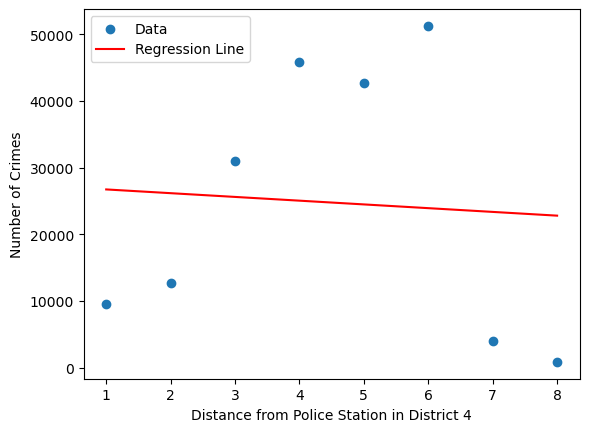

In [84]:
#Counting number of values below i km
agg_crime_dist_4 = pd.DataFrame(columns=['Distance', 'Count'])
count_list = []
agg_list = []
for i in range(1, 9):
    count_below_i = (dist_4['Distance'] < i).sum()
    agg_list.append(count_below_i)

print(len(agg_list))

idx_lst = []
count_list = agg_list.copy()
for i in range(1, 8):
    idx_lst.append(i)
    count_list[i] = agg_list[i] - agg_list[i-1]
idx_lst.append(8)

agg_crime_dist_4['Distance'] = idx_lst
agg_crime_dist_4['Count'] = count_list

display(agg_crime_dist_4)

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(agg_crime_dist_4['Distance'], agg_crime_dist_4['Count'])

# Print the regression results
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_value**2}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

# Plot the data and the regression line
plt.scatter(agg_crime_dist_4['Distance'], agg_crime_dist_4['Count'], label='Data')
plt.plot(agg_crime_dist_4['Distance'], intercept + slope * agg_crime_dist_4['Distance'], 'r', label='Regression Line')
plt.xlabel('Distance from Police Station in District 4')
plt.ylabel('Number of Crimes')
plt.legend()
plt.show()

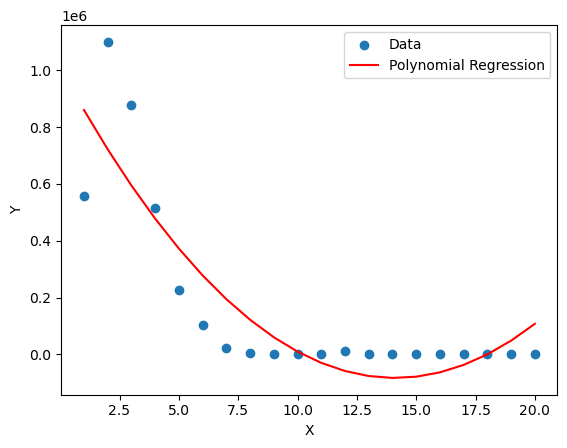

In [64]:
#Polynomial Regression after looking at curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

degree = 2  # Set the degree of the polynomial

poly = PolynomialFeatures(degree=degree)
X_poly = poly.fit_transform(agg_crime_dist[['Distance']])

# Fit linear regression model
model = LinearRegression()
model.fit(X_poly, agg_crime_dist['Count'])

# Visualize the data and the regression curve
plt.scatter(agg_crime_dist[['Distance']], agg_crime_dist['Count'], label='Data')
plt.plot(agg_crime_dist[['Distance']], model.predict(X_poly), color='red', label='Polynomial Regression')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()